In [1]:
BATCH_SIZE = 1024
#BATCH_SIZE = 2048
#BATCH_SIZE = 512
PAD_SIZE = 70

# Preprocessing

In [2]:
import os

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(3093453)

sns.set(
    context="talk",
    style="darkgrid"
)

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [4]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["interrupted", "solved"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(class_names)

Found 199898 files belonging to 2 classes.
Using 159919 files for training.


2023-10-19 10:35:53.885883: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-19 10:35:53.885908: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-19 10:35:53.885911: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-19 10:35:53.885964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-19 10:35:53.885992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 199898 files belonging to 2 classes.
Using 39979 files for validation.


In [5]:
for X,y in train_dataset.take(1):
    pass

In [6]:
#y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
#y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
#y = y == 1
print(y.numpy().mean())

0.3408203


In [7]:
df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: C
instance: MA
+-----------+
2D Packing MIP with Time Limit 4.3316688990958205 [s] in Truck P107037703
Stack 0 with items: ['0090016200_27022023037676', '0090016200_27022023035725']
Stack 1 with items: ['0090016200_27022023035144', '0090016200_27022023035144']
Stack 2 with items: ['0090016200_27022023035144', '0090016200_27022023020174']
Stack 3 with items: ['0090016200_27022023020174', '0090016200_27022023020174']
Stack 4 with items: ['0090016200_27022023016615', '0090016200_27022023013329']
Stack 5 with items: ['0090016200_27022023013329', '0090016200_27022023011216']
Stack 6 with items: ['0090016200_27022023010543', '0090016200_27022023007284']
Stack 7 with items: ['0090016200_27022023002073', '0090016200_27022023002073']
MIP Improvement - 2D Vol: 16.5 [m2] - packed 2D Vol Ratio: 0.5009107468123862 [%] - after 0.0 [s] without stacks:
Stack 4 missing: ['0090016200_27022023016615', '0090016200_27022023013329']
Stack 5 missing: ['0090016200_27022023013329', '0090016200_2702202

# Loading CSVs

In [8]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
22060301,null,90016900,"""169GB-30""","""756F09177R""","""SLI---1200""",1.6,1.2,0.93,0.5221,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
3043102,null,90016900,"""169GD-60""","""8200689884""","""SLI---1101""",1.9,1.2,0.75,0.271,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.705
27029901,null,90016900,"""GRE1""","""65832BZ50A""","""SLI---2112""",1.206,1.01,0.485,0.028632,0.0,"""C""","""BY""","""0090016900_270…",false,false,0.485
6681302,null,90016900,"""169GD-60""","""963010148R""","""SLI---2112""",1.206,1.01,1.093,0.08744,0.0,"""C""","""BY""","""0090016900_270…",false,false,1.093
22060301,null,90016900,"""169GB-10""","""743304967R""","""SFD---0760""",1.2,1.0,0.93,0.3803,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885


In [9]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730405""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730407""","""A""","""AS"""


In [10]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
])

truck_dims.collect().head()

truck_id,Length,Width,Weight,dataset,instance
str,f64,f64,f64,str,str
"""P187721701""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730401""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730403""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730405""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730407""",14.94,2.5,24.0,"""A""","""AS"""


In [11]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items
from utils.preprocessing import join_items, group_items_by_stack, join_truck_loading_order, append_truck_info

In [12]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .pipe(append_truck_info, truck_dims)
    .collect()
    .to_numpy()
)

X

array([[0, 2.75, 1.5, ..., False, '2-2-1', False],
       [0, 2.75, 1.5, ..., False, '2-2-1', False],
       [0, 2.75, 1.5, ..., False, '2-2-1', False],
       ...,
       [1023, 1.2, 1.0, ..., False, '1-1-1', False],
       [1023, 1.2, 1.0, ..., False, '1-1-1', False],
       [1023, 14.94, 2.5, ..., False, '0-0-0', True]], dtype=object)

In [13]:
def get_tensor_representation(X, packing_clm=6):
    
    indices = np.unique(X[:, 0])
    indices = np.sort(indices)

    # (batch_size, ?, features)
    X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

    # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
    #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
    
    for i, x in enumerate(X):
        packing_order = x[:,packing_clm]
        stops = np.unique(packing_order)
        stops = np.sort(stops)
        stops = {stop: j for j, stop in enumerate(stops)}
        stops = [stops[order] for order in packing_order]
        X[i][:,packing_clm] = stops

    # pad the variable length number of stacks into fixed
    #  (batch_size, pad_size, features)
    X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float64")
    # drop the index column (batch_size, pad_len, n_features)
    X = X[:,:,1:].astype(float)
    return X

c = get_tensor_representation(X)
c.shape

(1024, 70, 7)

In [14]:
c[1, :, :].round(3)

array([[ 0.8  ,  0.6  ,  0.549,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 0.8  ,  0.6  ,  0.573,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 0.8  ,  0.6  ,  0.549,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 0.8  ,  0.6  ,  0.578,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 0.8  ,  0.6  ,  0.466,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 0.8  ,  0.6  ,  0.49 ,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 0.8  ,  0.6  ,  0.431,  0.   ,  0.   ,  3.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.472,  0.   ,  1.   ,  1.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.472,  0.   ,  1.   ,  1.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.472,  0.   ,  1.   ,  1.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.472,  0.   ,  1.   ,  1.   ,  0.   ],
       [ 1.2  ,  1.   ,  0.735,  0.   ,  0.   ,  4.   ,  0.   ],
       [ 1.2  ,  1.   ,  0.755,  0.   ,  0.   ,  4.   ,  0.   ],
       [ 1.2  ,  1.   ,  0.748,  0.   ,  0.   ,  4.   ,  0.   ],
       [ 1.2  ,  1.   ,  0.742,  0.   ,  0.   ,  4.   ,  0.   ],
       [ 1.2  ,  1.   ,  

In [15]:
def get_additional_labels(df: pl.DataFrame) -> dict[str: np.array]:
    """
    """

    pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
    mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

    # mip_improvements: pl.Series[list[str]]
    # with entries according to the pattern, i.e all MIP improvement rows
    
    y_num_improvements = mip_improvements.list.len()-1
    
    y_improvement = y_num_improvements > 0

    y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)

    y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

    y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)

    y = {}
    y["num_improvements"] = y_num_improvements.to_numpy()
    y["improvement"] = y_improvement.to_numpy()
    y["packed_area_ratio"] = y_packed_area_ratio.to_numpy()
    y["packed_area"] = y_packed_area.to_numpy()
    y["last_update"] = y_last_update.to_numpy()    
    
    return y

#pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
#x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

In [16]:
#pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
#x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

In [17]:
def polars_transformation(X) -> (np.array, np.array):
    """

    Returns:
    --------
    X: np.array[float32]
        3D Feature Tensor of shape (Batch_size, Pad_size, n_features=7)

        - Batch_size: Truck Optimization Instances
        - Pad_size: Stacks (or Trucks), padded up to create tensors
        - n_features: Length, Width, Weight, L/W Forced Orientation
                      packing order, is_truck
    """
    
    df = pl.DataFrame({"raw": X.numpy().astype(str)})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)

    y = get_additional_labels(df)

    
    return X, y

#polars_transformation(X)

In [18]:
print(df[0,0])

dataset: C
instance: MA
+-----------+
2D Packing MIP with Time Limit 4.3316688990958205 [s] in Truck P107037703
Stack 0 with items: ['0090016200_27022023037676', '0090016200_27022023035725']
Stack 1 with items: ['0090016200_27022023035144', '0090016200_27022023035144']
Stack 2 with items: ['0090016200_27022023035144', '0090016200_27022023020174']
Stack 3 with items: ['0090016200_27022023020174', '0090016200_27022023020174']
Stack 4 with items: ['0090016200_27022023016615', '0090016200_27022023013329']
Stack 5 with items: ['0090016200_27022023013329', '0090016200_27022023011216']
Stack 6 with items: ['0090016200_27022023010543', '0090016200_27022023007284']
Stack 7 with items: ['0090016200_27022023002073', '0090016200_27022023002073']
MIP Improvement - 2D Vol: 16.5 [m2] - packed 2D Vol Ratio: 0.5009107468123862 [%] - after 0.0 [s] without stacks:
Stack 4 missing: ['0090016200_27022023016615', '0090016200_27022023013329']
Stack 5 missing: ['0090016200_27022023013329', '0090016200_2702202

In [19]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]
y_num_improvements = mip_improvements.list.len()-1
y_improvements = y_num_improvements > 0
y_improvements.mean()

0.4326171875

raw
list[str]
"[""MIP Improvement - 2D Vol: 16.5 [m2] - packed 2D Vol Ratio: 0.5009107468123862 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 27.39612 [m2] - packed 2D Vol Ratio: 0.8316976320582878 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 30.0 [m2] - packed 2D Vol Ratio: 0.9107468123861567 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 31.2 [m2] - packed 2D Vol Ratio: 0.947176684881603 [%] - after 0.7873136219568551 [s]""]"
"[""MIP Improvement - 2D Vol: 27.49212 [m2] - packed 2D Vol Ratio: 0.8346120218579236 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 28.0681 [m2] - packed 2D Vol Ratio: 0.8520977534911962 [%] - after 1.8164708614349365 [s]"", … ""MIP Improvement - 2D Vol: 28.64412 [m2] - packed 2D Vol Ratio: 0.869584699453552 [%] - after 7.325026964303106 [s]""]"
"[""MIP Improvement - 2D Vol: 28.8 [m2] - packed 2D Vol Ratio: 0.8743169398907105 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 32.4 [m2] - packed 2D Vol Ratio: 0.9836065573770492 [%] - after 0.020423163194209337 [s]""]"
"[""MIP Improvement - 2D Vol: 22.08 [m2] - packed 2D Vol Ratio: 0.6703096539162113 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 25.76 [m2] - packed 2D Vol Ratio: 0.7820279295689133 [%] - after 0.018106937408447266 [s]"", ""MIP Improvement - 2D Vol: 29.44 [m2] - packed 2D Vol Ratio: 0.8937462052216152 [%] - after 0.024621963500976562 [s]""]"
"[""MIP Improvement - 2D Vol: 31.27224 [m2] - packed 2D Vol Ratio: 0.9493697632058289 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 28.13443 [m2] - packed 2D Vol Ratio: 0.8541114146933819 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 28.4712 [m2] - packed 2D Vol Ratio: 0.8643351548269581 [%] - after 0.17412304878234863 [s]"", ""MIP Improvement - 2D Vol: 28.47124 [m2] - packed 2D Vol Ratio: 0.8643363691560414 [%] - after 0.6492452127858996 [s]""]"
"[""MIP Improvement - 2D Vol: 26.91517 [m2] - packed 2D Vol Ratio: 0.8170968427443838 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 26.9152 [m2] - packed 2D Vol Ratio: 0.8170977534911962 [%] - after 0.04949808120727539 [s]""]"


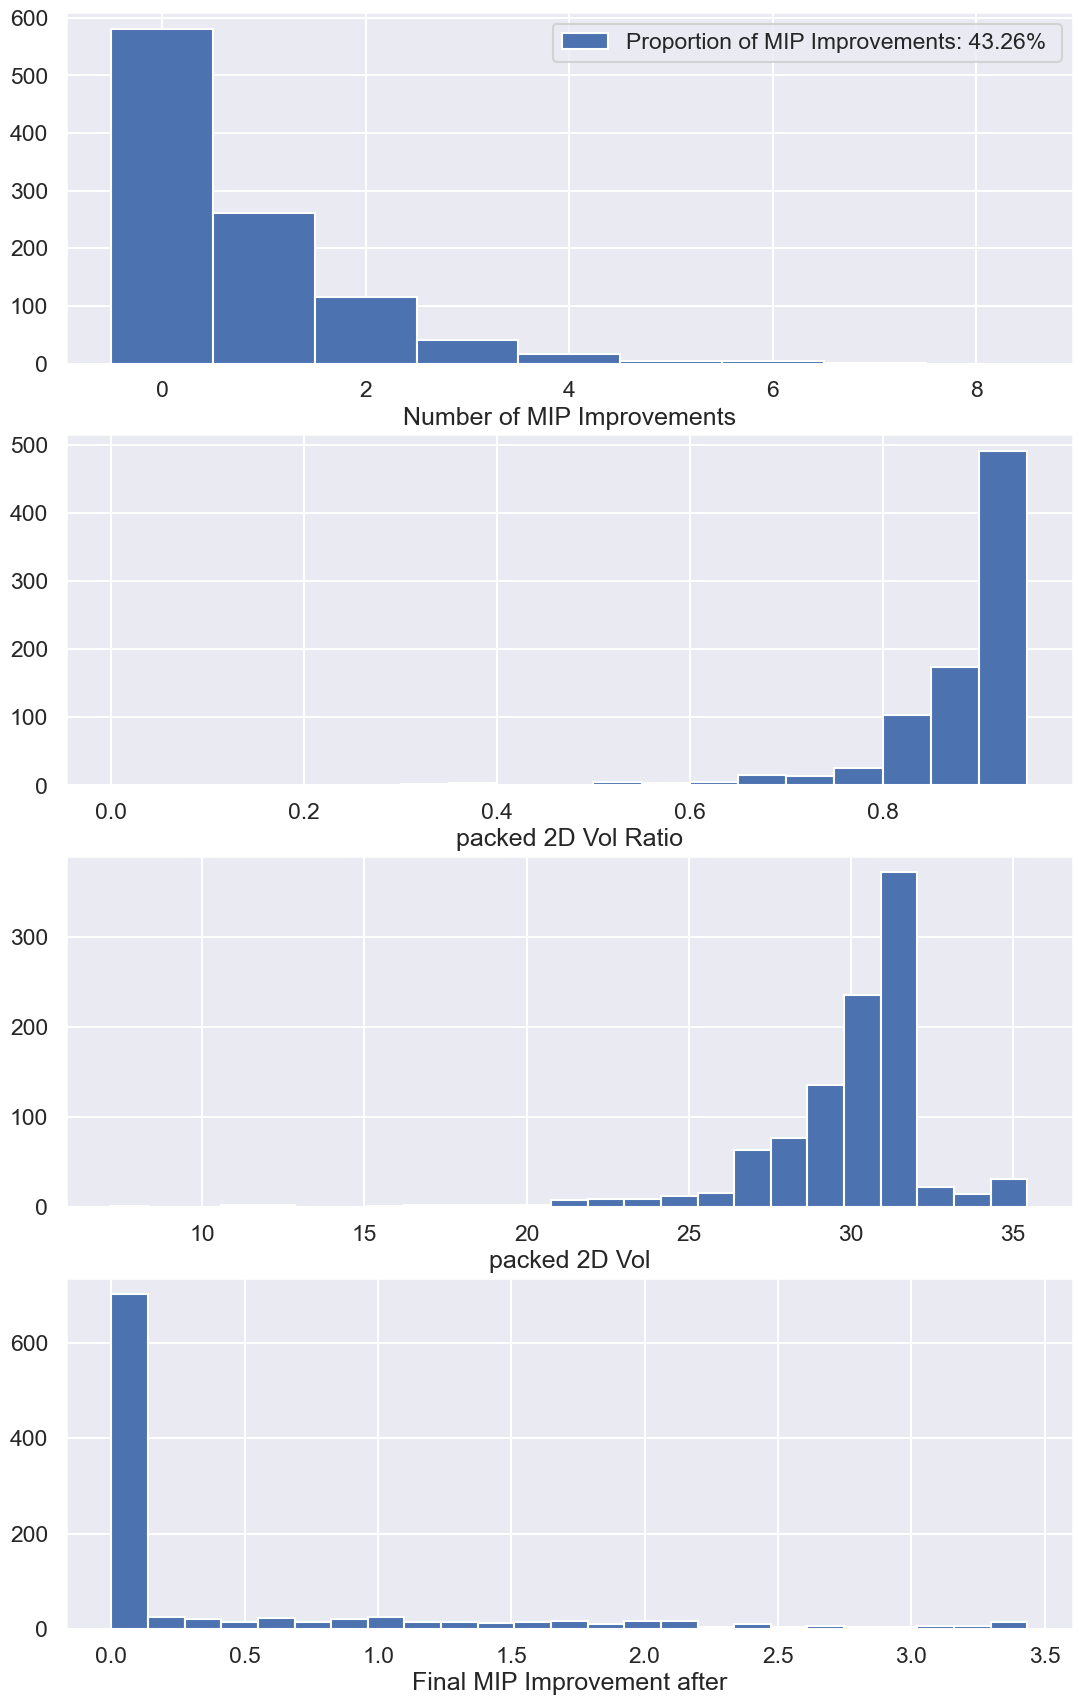

In [20]:
# pl df with columns 
# raw: list[str]
# where each element is a MIP Improvement - 2D ...
# With at least one element, the starting solution.
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

fig, ax = plt.subplots(4, figsize = (13, 21))

y_num_improvements = mip_improvements.list.len()-1
ax[0].hist(y_num_improvements, bins = np.arange(0, 10, 1)-0.5,
           label=f"Proportion of MIP Improvements: {(y_num_improvements>0).mean():.2%} ");
ax[0].set(xlabel="Number of MIP Improvements")

y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
ax[1].hist(y_packed_area_ratio, bins = np.arange(0, 1, 0.05));
ax[1].set(xlabel="packed 2D Vol Ratio")

#ax[2].hist((y_packed_area_ratio)**10, bins = 25);
#ax[2].set(xlabel="packed 2D Vol Ratio to the power 10")

y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
ax[2].hist(y_packed_area, bins = 25);
ax[2].set(xlabel="packed 2D Vol")


y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)
ax[3].hist(np.log1p(y_last_update), bins = 25);
ax[3].set(xlabel="Final MIP Improvement after")


ax[0].legend()

mip_improvements

# DNN

In [21]:
N_FEATURES = c.shape[-1]

# number of encoder blocks
n_blocks = 6 #3
num_heads = 4
key_dim = int(N_FEATURES/num_heads)
use_bias = True
## Encoder dropout in total and per layer
total_encoder_dropout = 0.3
encoder_dropout = 1-(1-total_encoder_dropout)**(1/n_blocks)
print(f"Encoder Layer Dropout of {encoder_dropout:.1%} resulting in a total Dropout of {total_encoder_dropout:.1%} over {n_blocks} encoders")


# number of fully connected layers with droput
#fully_connected_units = [] # [16]
#fully_connected_dropout_rate = 0.5

# activation function
activation = "gelu" # "relu" "gelu" "selu" "swish"




# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.8 # 0.9

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)

# Loss Function
#loss_fn = tf.keras.losses.BinaryCrossentropy(name="binary_crossentropy",)

# Focal Loss gamma:
gamma = 1.2 # 1.5
alpha = 1-y.numpy().mean() # inverse class frequency
alpha = 0.56

loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=gamma,
    alpha = alpha,
    name='binary_focal_crossentropy'
)



Encoder Layer Dropout of 5.8% resulting in a total Dropout of 30.0% over 6 encoders


## Architecture

In [22]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda

from utils.DNN.model_layers import TransformerEncoder

#help(Masking)
#help(MultiHeadAttention)
#help(Reshape)
#help(Dropout)
#help(Lambda)

In [23]:
# build a model using the functional API:
from keras import backend as K

from tensorflow.keras import Model


# Input
input_layer = Input(shape=(PAD_SIZE, N_FEATURES))

# Masking padded input
masking_layer = Masking(
    mask_value=0,
    input_shape=(PAD_SIZE, N_FEATURES),
    dtype=tf.float16, # float, # tf.float16
    name="MaskingLayer"
)
x = masking_layer(input_layer)

#batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
#x = batch_norm_layer(masking_layer)


# Encoder Block
for i in range(1, n_blocks+1):
    # Self attention with add and layer norm
    self_attention_layer = TransformerEncoder(
        num_heads=num_heads, key_dim=key_dim,
        dropout=encoder_dropout,               # Hyperparameter
        use_bias=use_bias,                     # usually False, but technically Hyperparameter
        idx = i,
        activation=activation,
        units = N_FEATURES,
        use_PreLN=True
    )
    x = self_attention_layer(
        x
    )
    



# After Attention, reduce to single dimension
add_across_dim = Lambda(
    lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
    output_shape=lambda s: (s[0], s[2]),
    name = "ReduceViaSum"
)

x = add_across_dim(x)


# Fully Connected Layer + Droput
#for i, units in enumerate(fully_connected_units):
#    
#    full_connected_layer = Dense(units=units, activation=activation,name=f"FullyConnectedLayer-{i+1}")
#    x = full_connected_layer(x)
#
#    dropout_layer = Dropout(fully_connected_dropout_rate,
#                            name = f"FullyConnectedDropoutLayer-{i+1}")
#    x = dropout_layer(x)


outputs = Dense(1, activation='sigmoid', name = "PredictionLayer")
outputs = outputs(x)

reshape = Lambda(lambda x: tf.squeeze(x))
outputs =  reshape(outputs)

model = Model(
    inputs=input_layer,
    #outputs=x,
    outputs=outputs,
)

In [24]:
_ = model(c) # just check if it works
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 7)]           0         
                                                                 
 MaskingLayer (Masking)      (None, 70, 7)             0         
                                                                 
 transformer_encoder (Trans  (None, 70, 7)             201       
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, 70, 7)             201       
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, 70, 7)             201       
 nsformerEncoder)                                                
                                                             

## Training Process Functions

In [25]:
mean_loss = keras.metrics.Mean(name = "Loss")
val_mean_loss = keras.metrics.Mean(name = "Val-Loss")




metrics = [
    tf.keras.metrics.Precision(name = "PRC"),
    tf.keras.metrics.Recall(name = "SNS"),
    tf.keras.metrics.AUC(curve='PR', name="AUC"),
    tf.keras.metrics.BinaryAccuracy(name = "ACC")
]

val_metrics = [
    tf.keras.metrics.Precision(name = "Val-PRC"),
    tf.keras.metrics.Recall(name = "Val-SNS"),
    tf.keras.metrics.AUC(curve='PR', name="Val-AUC"),
    tf.keras.metrics.BinaryAccuracy(name = "Val-ACC")
]

In [26]:
def early_stopping(history: pl.DataFrame, observe:str="Val-Loss", patience:int=3, increase:bool=False) -> bool:
    """
    Stop early if the last x=patience metrics of interest have decreased

    Parameters:
    -----------
    history: DataFrame
        dataframe with performance metrics, including the one of interest
        
    
    Returns:
    --------
    stop_early: bool
        indicates if we should stop the model trainig early
    """
    assert hasattr(history, "columns") # dataframe of some sort
    assert observe in history.columns  #
    
    diff = (history[observe] - history[observe].shift(1))
    diff = diff.tail(patience) # only last x=patience epochs are relevant

    if increase:
        stop_early:bool = all(diff > 0)
    else:
        stop_early:bool = all(diff <= 0)
    
    return stop_early

In [27]:
def early_stopping_no_improvement(history: pl.DataFrame, observe:str="Val-Loss", patience:int=3, increase:bool=False) -> bool:
    """
    Stop early if the last x=patience metrics of interest have decreased

    Parameters:
    -----------
    history: DataFrame
        dataframe with performance metrics, including the one of interest
        
    
    Returns:
    --------
    stop_early: bool
        indicates if we should stop the model trainig early
    """
    assert hasattr(history, "columns") # dataframe of some sort
    assert observe in history.columns  #
    
    x = history[observe]

    if increase:
        latest_improvement = x.arg_max()
    else:
        latest_improvement = x.arg_min()

    latest_improvement = len(x) - latest_improvement

    stop_early = latest_improvement > patience
    
    return stop_early

In [28]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**lr_decay

In [29]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " \t".join([f"{m.name:>10}: {m.result():.2%}"
                          for m in [loss] + (metrics or [])])
    
    end = ""# if iteration < total else "\n"
    print(f"\r{iteration+1}/{total}\t" + metrics,
          end=end)



In [30]:
@tf.function
def model_pass(X_batch, y_batch, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        y_pred = model(X_batch, training=training)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
        
        if training:
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    return loss, y_pred


## Model Training

In [31]:
n_epochs = 100
n_steps = len(train_dataset) // BATCH_SIZE

history = pl.DataFrame()

for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch}/{ n_epochs}")
    track = {"Epoch": epoch}
    
    for step, (X_batch, y_batch) in enumerate(train_dataset):
        y_batch = y_batch.numpy()
        X_batch, y_extra = polars_transformation(X_batch)

        y_batch = y_extra["improvement"]
        
        loss, y_pred = model_pass(X_batch, y_batch, training=True)
        mean_loss(loss)
        
        for metric in metrics:
            metric(y_batch.reshape(-1), y_pred.numpy().reshape(-1))
    
        print_status_bar(step, len(train_dataset), mean_loss, metrics)
    
    print("\n")

    track.update({m.name: m.result() for m in [mean_loss]+metrics})
    for metric in [mean_loss] + metrics:
        metric.reset_states()
    
    ##### VALIDATION STEP ####
    for step, (X_batch, y_batch) in enumerate(val_dataset):
        y_batch = y_batch.numpy()
        X_batch, y_extra = polars_transformation(X_batch)

        y_batch = y_extra["improvement"]
        
        loss, y_pred = model_pass(X_batch, y_batch, training=False)
        val_mean_loss(loss)
        
        for metric in val_metrics:
            metric(y_batch.reshape(-1), y_pred.numpy().reshape(-1))
    
        print_status_bar(step, len(val_dataset), mean_loss, val_metrics)
        
    
    track.update({m.name: m.result() for m in [val_mean_loss]+val_metrics})
    for metric in [val_mean_loss] + val_metrics:
        metric.reset_states()
    
    print("\n", "-"*120, "\n")
    history = pl.concat([history, pl.DataFrame(track)])


    #### LEARNING RATE UPDATE ####
    optimizer.lr = geometric_decay(epoch, initial_lr, lr_decay)
    
    
    ##### EARLY STOPPING ####
    # if no drop in Loss after 3 Epochs:
    #if early_stopping(history, "Val-Loss", patience = 3):
    #if early_stopping(history, "Val-AUC", patience = 3, increase=False):
    if early_stopping_no_improvement(history, "Val-Loss", patience = 1):
        break

Epoch 1/100


2023-10-19 10:36:19.841444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


157/157	      Loss: 28.37% 	       PRC: 59.02% 	       SNS: 42.27% 	       AUC: 58.86% 	       ACC: 62.83%

40/40	      Loss: 0.00% 	   Val-PRC: 67.98% 	   Val-SNS: 47.33% 	   Val-AUC: 67.12% 	   Val-ACC: 67.96%
 ------------------------------------------------------------------------------------------------------------------------ 

Epoch 2/100
157/157	      Loss: 26.00% 	       PRC: 66.26% 	       SNS: 52.14% 	       AUC: 67.86% 	       ACC: 68.24%

40/40	      Loss: 0.00% 	   Val-PRC: 65.60% 	   Val-SNS: 60.00% 	   Val-AUC: 70.43% 	   Val-ACC: 69.46%
 ------------------------------------------------------------------------------------------------------------------------ 

Epoch 3/100
157/157	      Loss: 24.97% 	       PRC: 67.67% 	       SNS: 57.19% 	       AUC: 71.24% 	       ACC: 70.07%

40/40	      Loss: 0.00% 	   Val-PRC: 70.73% 	   Val-SNS: 55.41% 	   Val-AUC: 74.31% 	   Val-ACC: 71.14%
 -------------------------------------------------------------------------------------------

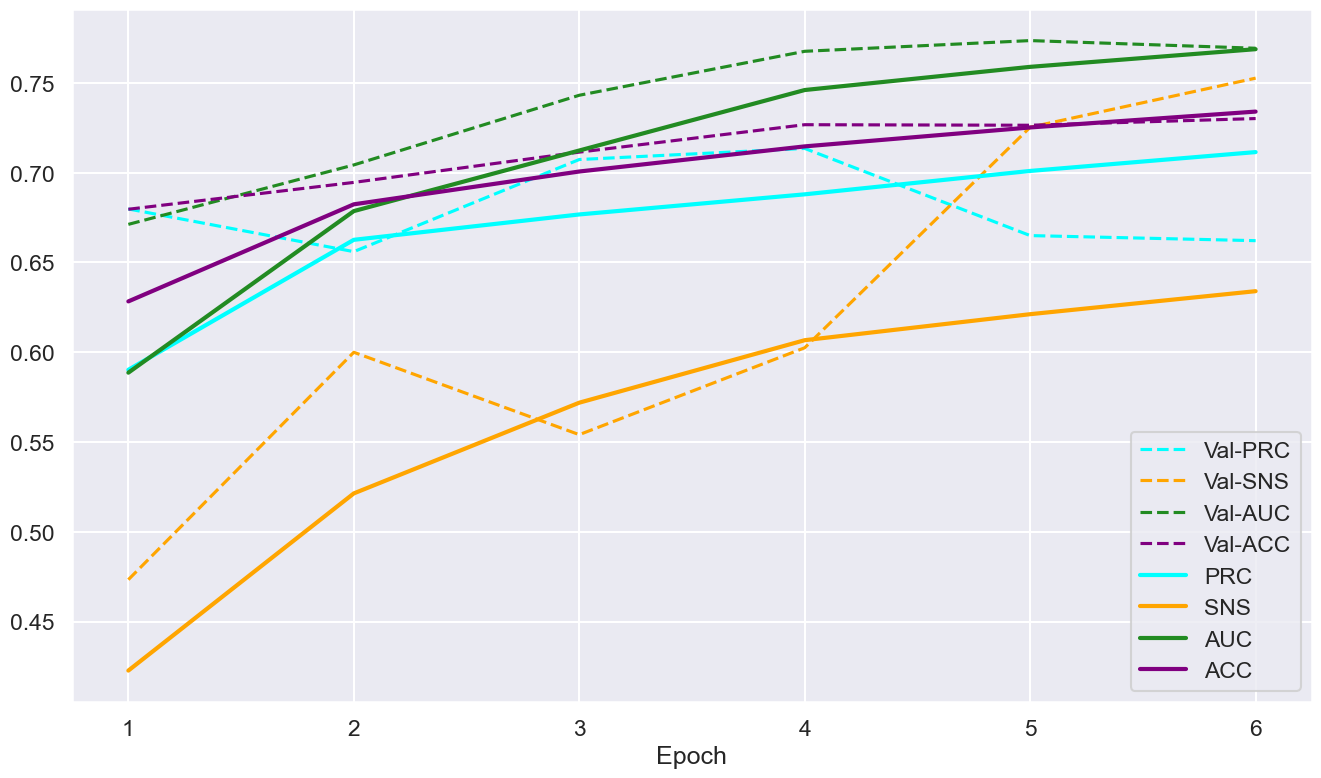

In [32]:
history = history.to_pandas().set_index("Epoch")

clms = history.columns

fig, ax = plt.subplots(figsize=(16, 9))

colors = ["cyan", "orange", "forestgreen", "purple"]

history[clms[clms.str.contains("Val-") & ~clms.str.contains("Loss")]].plot(ls="--", ax=ax, color = colors)
history[clms[~clms.str.contains("Val-") & ~clms.str.contains("Loss")]].plot(ls="-", ax=ax, color = colors, lw=3);

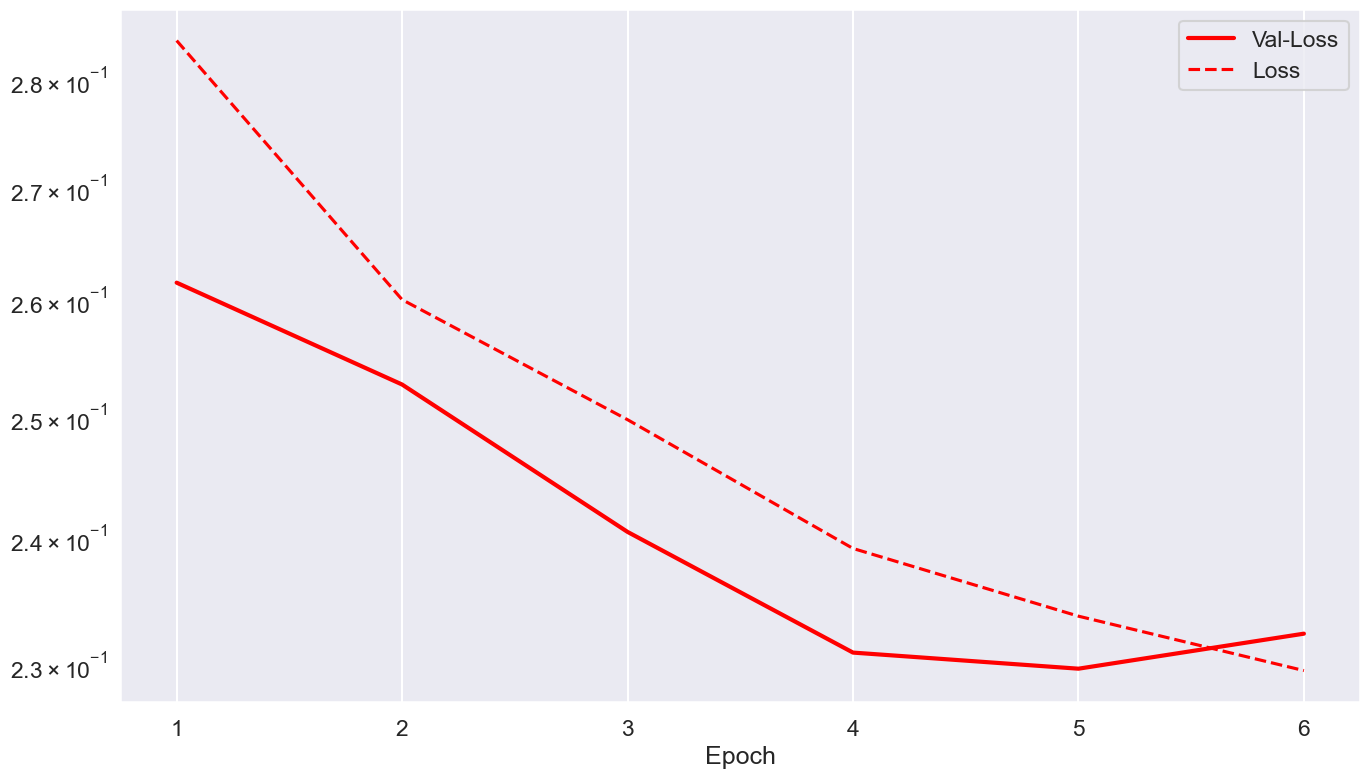

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))

colors = ["red"]

history[clms[clms.str.contains("Val-") & clms.str.contains("Loss")]].plot(ls="-", ax=ax, color = colors, lw=3)
history[clms[~clms.str.contains("Val-") & clms.str.contains("Loss")]].plot(ls="--", ax=ax, color = colors);
plt.yscale("log")

Tradeoff between Sensitivity and Precision can be seen very good here.
Most likely explanation:
- the bias of the final layer before the sigmoid has changed drastically.
- if the bias increases, predicted probabilities increase. This means more found solved cases and higher Sensitivity
- if the bias decreases, predicted probabilities decrease. This means less found solved cases, only the more certain cases. Higher Precision